In [44]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Preprocessor
from sklearn.preprocessing import LabelEncoder,StandardScaler
from imblearn.combine import SMOTEENN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

import pickle
import warnings

In [45]:
df = pd.read_csv('../data/Bank Customer Churn Prediction.csv')

In [46]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [47]:
df_cp = df.drop(columns=['churn'],axis=1)
df_cp = df.drop(columns=['customer_id'],axis=1)

In [48]:
df_cp.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Preprocessing

In [49]:
final_df = df_cp.copy()

In [50]:
final_df = pd.get_dummies(final_df,drop_first=True)

In [51]:
final_df

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


In [52]:
X=final_df.drop('churn',axis=1)
X.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [53]:
Y=final_df['churn']
Y.head()

0    1
1    0
2    1
3    0
4    0
Name: churn, dtype: int64

In [54]:
X_bal,Y_bal=SMOTEENN().fit_resample(X,Y)

In [55]:
Y_bal.value_counts()

1    3593
0    2975
Name: churn, dtype: int64

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bal,Y_bal,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((5254, 11), (1314, 11))

In [57]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Model

In [58]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [59]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]   
}

Logistic Regression
Model performance for Training set
- Root Mean Squared Error: 0.4456
- Mean Absolute Error: 0.1985
- R2 Score: 0.1983
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4541
- Mean Absolute Error: 0.2062
- R2 Score: 0.1698
- Accuracy Score: 0.7938


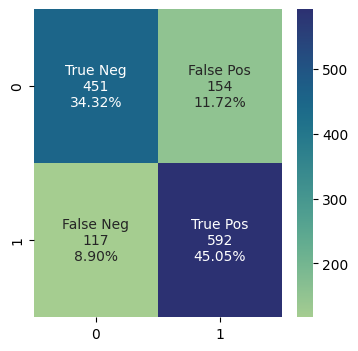



K-Neighbors Classifier
Model performance for Training set
- Root Mean Squared Error: 0.3550
- Mean Absolute Error: 0.1260
- R2 Score: 0.4911
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4336
- Mean Absolute Error: 0.1880
- R2 Score: 0.2434
- Accuracy Score: 0.8120


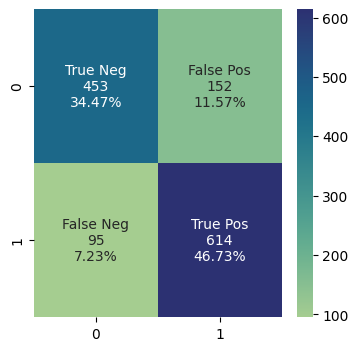



Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4336
- Mean Absolute Error: 0.1880
- R2 Score: 0.2434
- Accuracy Score: 0.8120


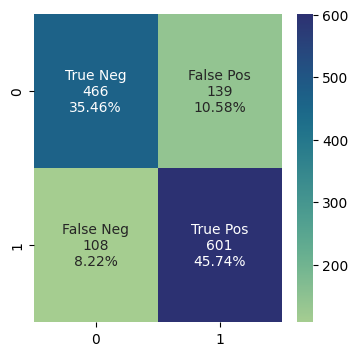



Random Forest Classifier
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3722
- Mean Absolute Error: 0.1385
- R2 Score: 0.4425
- Accuracy Score: 0.8615


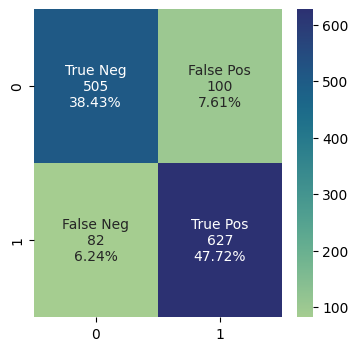



XGBClassifier
Model performance for Training set
- Root Mean Squared Error: 0.0839
- Mean Absolute Error: 0.0070
- R2 Score: 0.9716
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3412
- Mean Absolute Error: 0.1164
- R2 Score: 0.5313
- Accuracy Score: 0.8836


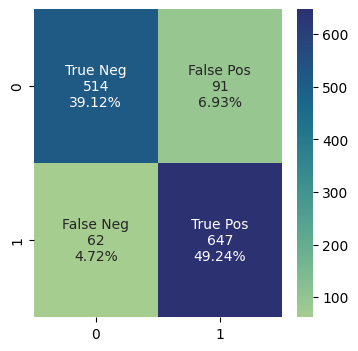



CatBoosting Classifier
Model performance for Training set
- Root Mean Squared Error: 0.2510
- Mean Absolute Error: 0.0630
- R2 Score: 0.7456
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3597
- Mean Absolute Error: 0.1294
- R2 Score: 0.4792
- Accuracy Score: 0.8706


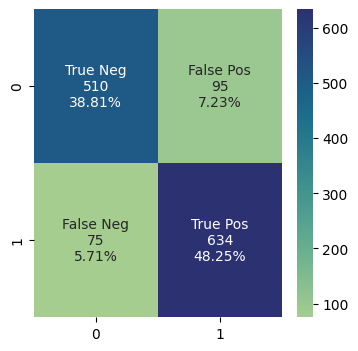



AdaBoost Classifier
Model performance for Training set
- Root Mean Squared Error: 0.3912
- Mean Absolute Error: 0.1530
- R2 Score: 0.3820
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4166
- Mean Absolute Error: 0.1735
- R2 Score: 0.3016
- Accuracy Score: 0.8265


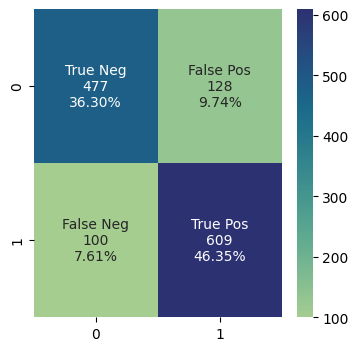

In [60]:
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}
model_list = []
r2_list =[]
acc_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    acc = accuracy_score(y_test,y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print("- Accuracy Score: {:.4f}".format(acc))
    r2_list.append(model_test_r2)
    acc_list.append(acc)
    conf_matrix = confusion_matrix(y_test,y_test_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(4,4))
    ax = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='crest')
    plt.show()
    print('='*35)
    print('\n')

In [61]:
r2_score_df=pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2 Score']).sort_values(by=["R2 Score"],ascending=False)
r2_score_df

,Model Name,R2 Score
4,XGBClassifier,0.531311
5,CatBoosting Classifier,0.479234
3,Random Forest Classifier,0.442474
6,AdaBoost Classifier,0.301561
1,K-Neighbors Classifier,0.243358
2,Decision Tree,0.243358
0,Logistic Regression,0.169838


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'XGBClassifier'),
  Text(1, 0, 'CatBoosting Classifier'),
  Text(2, 0, 'Random Forest Classifier'),
  Text(3, 0, 'AdaBoost Classifier'),
  Text(4, 0, 'K-Neighbors Classifier'),
  Text(5, 0, 'Decision Tree'),
  Text(6, 0, 'Logistic Regression')])

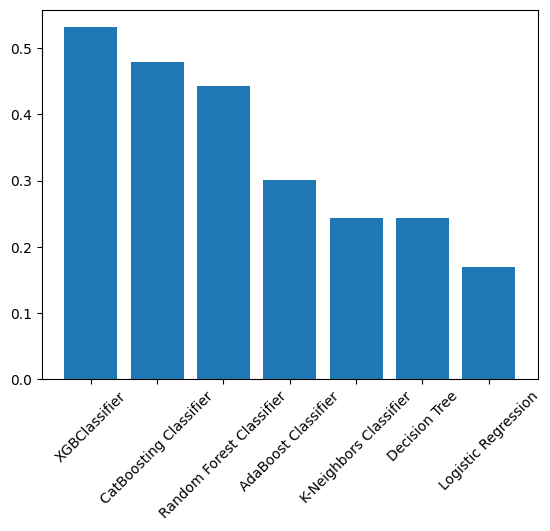

In [62]:
plt.bar(r2_score_df['Model Name'],r2_score_df['R2 Score'])
plt.xticks(rotation=45)

In [63]:
acc_score_df=pd.DataFrame(list(zip(model_list, acc_list)), columns=['Model Name', 'Accuracy Score']).sort_values(by=["Accuracy Score"],ascending=False)
acc_score_df

,Model Name,Accuracy Score
4,XGBClassifier,0.883562
5,CatBoosting Classifier,0.870624
3,Random Forest Classifier,0.861492
6,AdaBoost Classifier,0.826484
1,K-Neighbors Classifier,0.812024
2,Decision Tree,0.812024
0,Logistic Regression,0.793760


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'XGBClassifier'),
  Text(1, 0, 'CatBoosting Classifier'),
  Text(2, 0, 'Random Forest Classifier'),
  Text(3, 0, 'AdaBoost Classifier'),
  Text(4, 0, 'K-Neighbors Classifier'),
  Text(5, 0, 'Decision Tree'),
  Text(6, 0, 'Logistic Regression')])

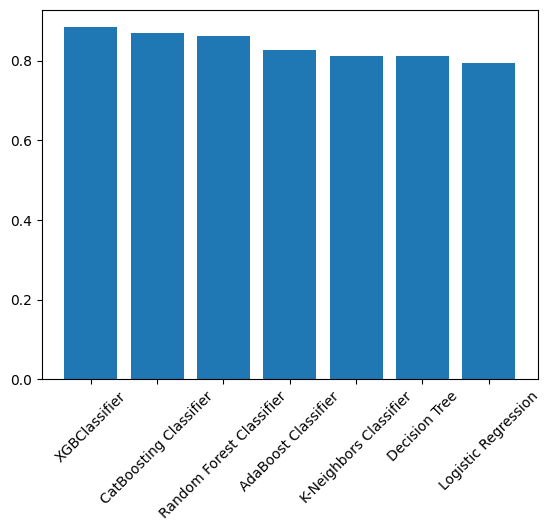

In [64]:
plt.bar(acc_score_df['Model Name'],acc_score_df['Accuracy Score'])
plt.xticks(rotation=45)

In [90]:
params={
 "learning_rate"    : [0.1, 0.15, 0.2, 0.15, 0.3, 0.35 ],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7, 9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}
xgb_model = XGBClassifier()
random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=5,cv=5,verbose=3)
random_search.fit(X_train,y_train)
random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [86]:
xgb_model = XGBClassifier()
from sklearn.model_selection import cross_val_score
score = cross_val_score(xgb_model, X_bal, Y_bal, cv=10)
score.mean()
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [87]:
prediction = xgb_model.predict(X_test)

In [88]:
accuracy = accuracy_score(y_test, prediction)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.36%


0.8835616438356164


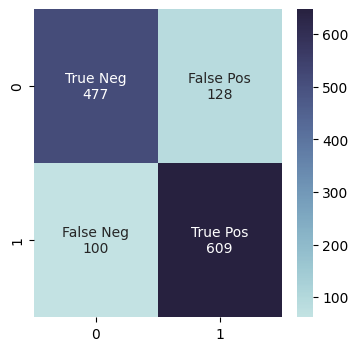

In [89]:
conf_matrix = confusion_matrix(y_test,prediction)
group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}" for v1,v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(4,4))
ax = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
print(accuracy_score(y_test,prediction))

Save to pickle model

In [70]:
filename = '../model/model.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))